In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [22]:
import os

# 서비스 계정 키 경로 설정
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"/home/eunyu/sprintda05-eunyu-a9946f7dea9c.json"

# GCS의 Parquet 파일 경로
gcs_path = 'gs://final_project_enuyu/data/final_project/votes/accounts_attendance.parquet'

# 데이터 불러오기
attendance_df = pd.read_parquet(gcs_path, engine='pyarrow')
attendance_df

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453
...,...,...,...
349632,360501,[],897005
349633,360502,"[""2024-05-09""]",1407059
349634,360503,"[""2024-05-09""]",1583727
349635,360504,"[""2024-05-09""]",1392372


In [23]:
attendance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349637 entries, 0 to 349636
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    349637 non-null  int64 
 1   attendance_date_list  349637 non-null  object
 2   user_id               349637 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.0+ MB


In [24]:
attendance_df.describe(include="all")

,id,attendance_date_list,user_id
count,349637.000000,349637,3.496370e+05
unique,NaN,128837,NaN
top,NaN,[],NaN
freq,NaN,20945,NaN
mean,180550.143772,NaN,1.247187e+06
std,104168.322237,NaN,2.127986e+05
min,1.000000,NaN,8.321510e+05
25%,90432.000000,NaN,1.065813e+06
50%,180749.000000,NaN,1.261234e+06
75%,270674.000000,NaN,1.437486e+06


In [25]:
attendance_df.isnull().sum()

id                      0
attendance_date_list    0
user_id                 0
dtype: int64

In [26]:
import ast

# 리스트 문자열을 실제 리스트로 변환
attendance_df['attendance_parsed'] = attendance_df['attendance_date_list'].apply(lambda x: ast.literal_eval(x))

# 출결 일수 컬럼 생성
attendance_df['attendance_count'] = attendance_df['attendance_parsed'].apply(len)

# 출결 일수 상위 5명 및 하위 5명
top_attendees = attendance_df.sort_values(by='attendance_count', ascending=False).head()
bottom_attendees = attendance_df.sort_values(by='attendance_count', ascending=True).head()

# 출결 일수 통계 요약
attendance_count_summary = attendance_df['attendance_count'].describe()

(top_attendees[['user_id', 'attendance_count']],
 bottom_attendees[['user_id', 'attendance_count']],
 attendance_count_summary)

(       user_id  attendance_count
 38551  1499325               310
 30166  1314665               302
 21940  1467385               277
 8741   1491003               274
 11678  1467221               273,
         user_id  attendance_count
 268832  1555146                 0
 24140   1438566                 0
 315638  1573222                 0
 315640  1573131                 0
 172434  1117953                 0,
 count    349637.000000
 mean          6.356098
 std           9.158459
 min           0.000000
 25%           1.000000
 50%           3.000000
 75%           8.000000
 max         310.000000
 Name: attendance_count, dtype: float64)

### 출결일수 분포

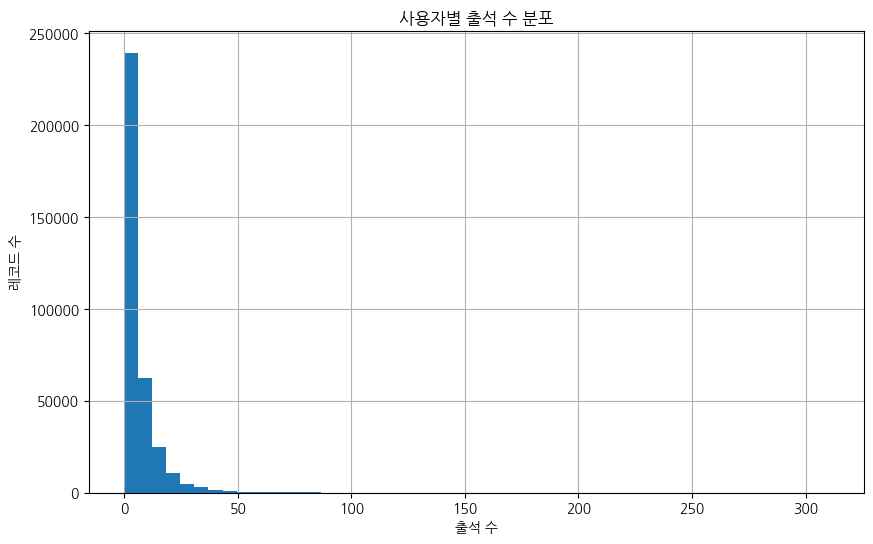

In [27]:
plt.figure(figsize=(10, 6))
attendance_df['attendance_count'].hist(bins=50)
plt.title("사용자별 출석 수 분포")
plt.xlabel("출석 수")
plt.ylabel("레코드 수")
plt.grid(True)
plt.show()

 1. 출석 수 분포
- 대부분의 사용자는 출석 수가 0~10일 사이에 분포함.
- 롱테일 분포 형태로 일부 사용자만 매우 많은 출석 기록을 가짐.
- 출석 수 50일 이상은 거의 없음.



In [28]:
# 2. 출결이 아예 없는 유저 비율 확인 ([] 빈 리스트)
no_attendance_count = (attendance_df['attendance_count'] == 0).sum()
no_attendance_ratio = no_attendance_count / len(attendance_df)

no_attendance_count, no_attendance_ratio


(20945, 0.059904987172410246)

2. 출석 0회 사용자 비율
- 출석 0회 사용자 수: 20,945명
- 전체 대비 약 5.96%의 사용자가 출석 기록 없음.

In [29]:
# 3. 유저 기준으로 그룹화한 출결 횟수 통계 (유저별로 여러 기록이 있을 수도 있으므로)
user_summary = attendance_df.groupby('user_id')['attendance_count'].sum().reset_index(name='total_attendance')
user_summary_stats = user_summary['total_attendance'].describe()

user_summary_stats

count    349637.000000
mean          6.356098
std           9.158459
min           0.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         310.000000
Name: total_attendance, dtype: float64

In [30]:
# 4. 출결일수 기준 상위/하위 유저 추출
top_users = user_summary.sort_values(by='total_attendance', ascending=False).head()
bottom_users = user_summary.sort_values(by='total_attendance', ascending=True).head()

top_users, bottom_users

(        user_id  total_attendance
 297587  1499325               310
 199839  1314665               302
 278948  1467385               277
 292760  1491003               274
 278858  1467221               273,
         user_id  total_attendance
 180378  1273588                 0
 157892  1224577                 0
 66634   1016516                 0
 288542  1483848                 0
 288553  1483865                 0)

#### 일부 사용자만 매우 많은 출석 기록

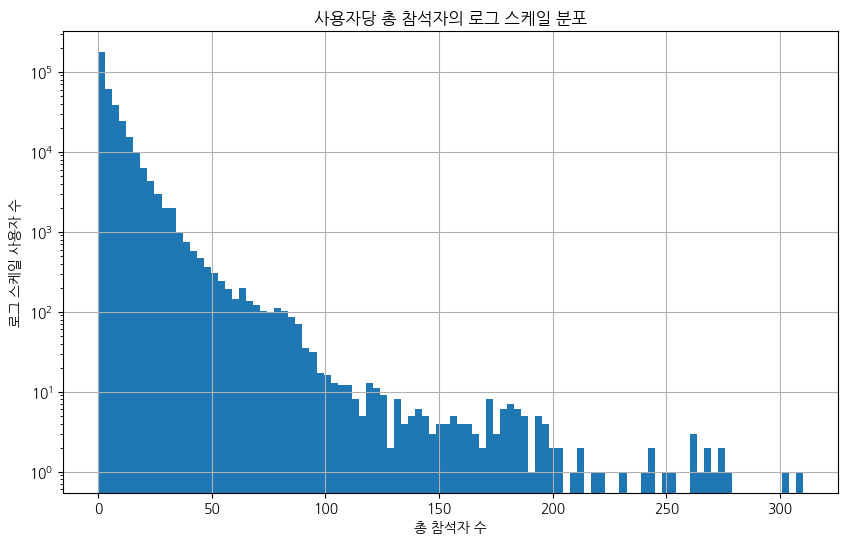

In [31]:
# 출석 수 분포 로그 스케일로 시각화

plt.figure(figsize=(10, 6))
plt.hist(user_summary['total_attendance'], bins=100, log=True)
plt.title('사용자당 총 참석자의 로그 스케일 분포')
plt.xlabel('총 참석자 수')
plt.ylabel('로그 스케일 사용자 수')
plt.grid(True)
plt.show()


In [32]:
# 상위 1% 기준 출석 수
threshold_99 = user_summary['total_attendance'].quantile(0.99)

# 상위 1% 사용자 수
top_1_percent_count = (user_summary['total_attendance'] >= threshold_99).sum()

# 전체 대비 비율
top_1_percent_ratio = top_1_percent_count / len(user_summary)

print(f"상위 1% 기준 출석 수: {threshold_99}")
print(f"상위 1% 사용자 수: {top_1_percent_count}")
print(f"전체 사용자 대비 비율: {top_1_percent_ratio:.2%}")

상위 1% 기준 출석 수: 41.0
상위 1% 사용자 수: 3639
전체 사용자 대비 비율: 1.04%


### 상위 vs 전체 사용자 요일별 출석 비교

In [33]:
# 상위 1% 유저 ID 리스트 추출
top_users_list = user_summary[user_summary['total_attendance'] >= 41]['user_id']


In [34]:
# 전체 데이터를 user_id 단위로 explode
attendance_df['attendance_date'] = attendance_df['attendance_parsed'].apply(lambda x: pd.to_datetime(x))
df_exploded = attendance_df[['user_id', 'attendance_date']].explode('attendance_date')

In [35]:
df_exploded['weekday'] = df_exploded['attendance_date'].dt.day_name()
df_exploded['month'] = df_exploded['attendance_date'].dt.month

In [36]:
# 상위 사용자만 필터링
df_top = df_exploded[df_exploded['user_id'].isin(top_users_list)]

In [37]:
# 요일별 출석 수 비교
weekday_total = df_exploded['weekday'].value_counts().sort_index()
weekday_top = df_top['weekday'].value_counts().sort_index()

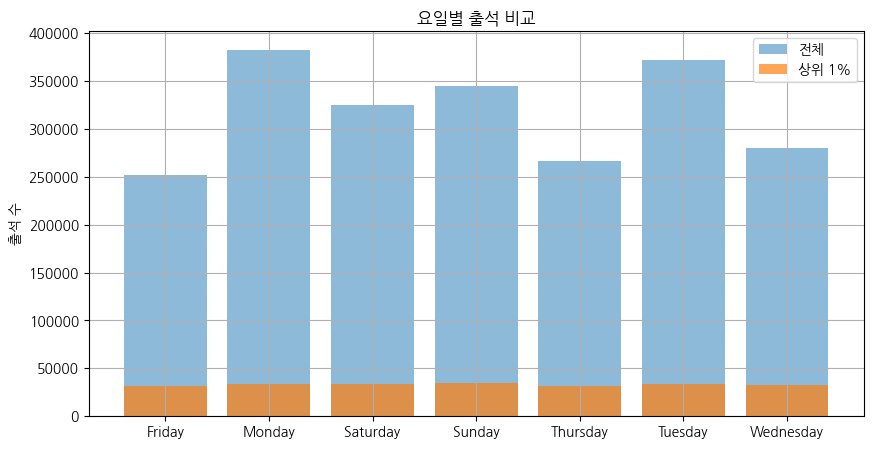

In [38]:
# 시각화

plt.figure(figsize=(10,5))
plt.bar(weekday_total.index, weekday_total.values, label='전체', alpha=0.5)
plt.bar(weekday_top.index, weekday_top.values, label='상위 1%', alpha=0.7)
plt.title('요일별 출석 비교')
plt.ylabel('출석 수')
plt.legend()
plt.grid(True)
plt.show()

1. 월요일(Monday)과 화요일(Tuesday):
- 전체 출석자 수가 가장 많음.
- 상위 1% 사용자 역시 이틀 간 가장 활발하게 출석함.
- 주말이 끝나고 출석이 활성화되는 패턴이 있음.
2. 금요일(Friday)과 목요일(Thursday):
- 전체 출석은 비교적 낮음.
- 특히 목요일은 전체 출석 수가 가장 적음.
3. 상위 1% 유저의 기여:
- 요일에 상관없이 상위 1% 사용자의 출석 기여는 항상 일정 수준 유지됨.
- 출석 수치의 절대값은 전체 사용자에 비해 작지만, 비율적으로는 일정하거나 요일에 따라 상대적으로 커질 수 있음.

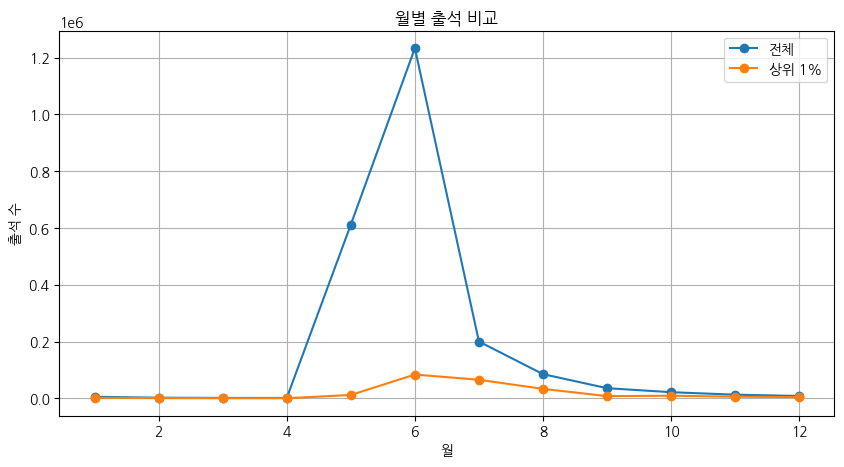

In [39]:
month_total = df_exploded['month'].value_counts().sort_index()
month_top = df_top['month'].value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.plot(month_total.index, month_total.values, label='전체', marker='o')
plt.plot(month_top.index, month_top.values, label='상위 1%', marker='o')
plt.title('월별 출석 비교')
plt.xlabel('월')
plt.ylabel('출석 수')
plt.legend()
plt.grid(True)
plt.show()
